In [1]:
from importlib import reload
try:
    core = reload(core)
except:
    import core
from core import *

In [2]:
import os
import io
import matlab.engine
import copy
import od.engine
from numpy import random
from od.network.allocator import ResourceAllocatorNomaApprox
import time

--- 4.00543212890625e-05 seconds ---


In [3]:
print(matlab.engine.find_matlab())
print(os.getcwd())
MATLAB_ENG = matlab.engine.connect_matlab()
od.engine.MATLAB_ENG = MATLAB_ENG

('MATLAB_2716221',)
/home/OD/repos/ProjectSumo


In [4]:
MATLAB_ENG.addpath(os.getcwd() + "/matlab/")
MATLAB_ENG.addpath(os.getcwd() + "/matlab/SelectCQI_bySNR/")
MATLAB_ENG.addpath(os.getcwd() + "/matlab/PlannerV1/")
print("Done")

Done


In [12]:
def GenerateRandomAllocRequest(number_of_general_groups):
    QoS_GP_CONF = [
        [
            {
                'gid': float(1),
                'qos': 1.0,
                **{'rbf_w': 1.0, 'rbf_h': 2.0},
                'sinr_max': float(random.randint(150, 300) / 10),
                **random.choice([
                    {'pwr_req_dBm': 22.956, 'pwr_ext_dBm': 3.034702226027002},
                    {'pwr_req_dBm': 22.959, 'pwr_ext_dBm': 2.729511581869497},
                    {'pwr_req_dBm': 22.955, 'pwr_ext_dBm': 3.1318014527925526}
                ]),
                'rem_bits': float(random.randint(1000, 50000)),
                'mem_num': float(random.randint(3, 20)),
                'eager_rate': float(random.randint(1000, 5000) / 10)
            }
        ],
        [
            {
                'gid': float(i + 2),
                'qos': 2.0,
                **{'rbf_w': 2.0, 'rbf_h': 1.0},
                'sinr_max': float(random.randint(150, 300) / 10),
                **random.choice([
                    {'pwr_req_dBm': 22.956, 'pwr_ext_dBm': 3.034702226027002},
                    {'pwr_req_dBm': 22.959, 'pwr_ext_dBm': 2.729511581869497},
                    {'pwr_req_dBm': 22.955, 'pwr_ext_dBm': 3.1318014527925526}
                ]),
                'rem_bits': float(random.randint(1000, 50000)),
                'mem_num': float(random.randint(3, 20)),
                'eager_rate': float(random.randint(1000, 5000) / 10)
            }
            for i in range(number_of_general_groups)
        ]
    ]
    RES_CONF = {'rbf_h': 50.0 , 'rbf_w': 2.0, 'max_pwr_dBm': 23.0}
    return RES_CONF, QoS_GP_CONF

In [34]:
num_general_group_range = [ i+1 for i in range(50)]
num_random_samples = 100
exec_time = [
    [
        [
            float("inf") 
            for _ in range(num_random_samples)
        ]
         for _ in num_general_group_range
    ] 
    for _ in range(2)
]
out = io.StringIO()
for i, s in enumerate(num_general_group_range):
    for _s in range(num_random_samples):
        RES_CONF,QoS_GP_CONF =  GenerateRandomAllocRequest(s)
        opt_beg = time.time()
        MATLAB_ENG.PlannerV1(RES_CONF, QoS_GP_CONF, stdout=out)
        opt_end = time.time()
        allocator = ResourceAllocatorNomaApprox(copy.deepcopy(RES_CONF),copy.deepcopy(QoS_GP_CONF))
        apr_beg = time.time()
        alloc_report = allocator()  
        apr_end = time.time()
        exec_time[0][i][_s] =  opt_end - opt_beg
        exec_time[1][i][_s] = apr_end - apr_beg

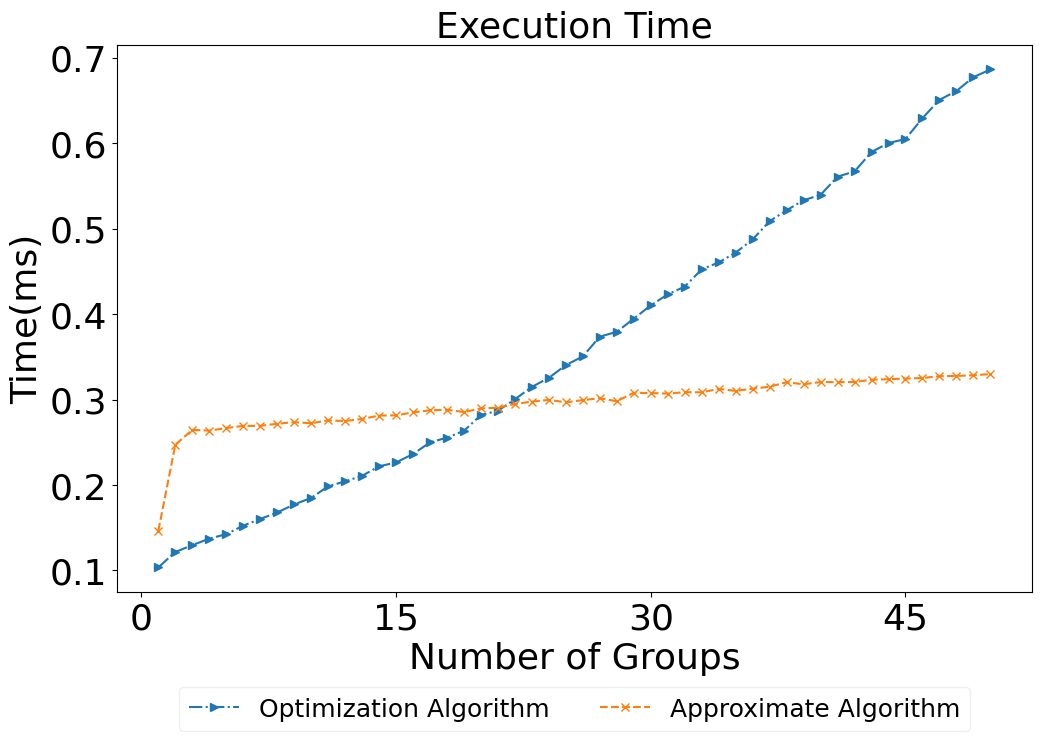

In [36]:
import numpy
graphs={}
graphs["Execution Time"] =  Graph("Allocation Execution Time","Number of Groups","Time(ms)")
graphs["Execution Time"].addLine(Line("Optimization Algorithm", num_general_group_range,[ numpy.mean(sorted(l)[10:-10]) for l in exec_time[0]]))
graphs["Execution Time"].addLine(Line("Approximate Algorithm",num_general_group_range,[ numpy.mean(sorted(l)[10:-10]) for l in exec_time[1]]))
ShowGraphs(graphs,True)